# Week 8 Transit Gaps Group Collaboration Notebook
## Team members: Monisha Reginald, Lucy Briggs, Carolyn Pugh

### Description
<b>Research Question</b>: Where do gaps in access to grocery stores by non-automobile modes exist for seniors who live in the city of Los Angeles?<br>
<b>Notbook Purpose:</b> In this notebook, we will consolidate and provide additional narrative around the work we have developed so far as part of our preparation for our final project.

### Import Libraries

In [1]:
# Import basic packages.
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import fiona 
import numpy as np
import math

# Import packages for plots and maps. 
import folium
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import contextily as ctx
import plotly.express as px

# Import libraries for doing network analysis with open street map. 
import networkx as nx
import osmnx as ox

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


### Part 1: Where do senior residents live within the City of LA? 
In this section, we analyze which areas have higher or lower densities of older residents using census data.  We look at both the block group and neighborhood level.

### Seniors Basemap

In [2]:
#read our pre-made GeoJSON
seniors = gpd.read_file('seniors_update.geojson')
seniors.columns=['BG20', 'FIPS', 'Total Pop Density', 'Official Area', 'neighborhood',
'Total Pop', 'Age 65-74', 'Age 75-84', 'Age 85+', 'Total Senior Pop',
'Pct Seniors', 'pctcat', 'geometry']

seniors.head()

BG20          FIPS  Total Pop Density  Official Area neighborhood  \
0  1233043  060371233043          21426.740       0.045317  Valley Glen   
1  2075021  060372075021          49546.610       0.024623     Downtown   
2  2012001  060552012001          16396.350       0.170221    El Sereno   
3  2016021  060552016021           9596.549       0.071276    El Sereno   
4  1218022  060871218022          10497.200       0.183668   Sun Valley   

   Total Pop  Age 65-74  Age 75-84  Age 85+  Total Senior Pop  Pct Seniors  \
0        971        182        230      197               609    62.718847   
1       1220         63        516      182               761    62.377049   
2        725        238        137       42               417    57.517241   
3        772        333         51       58               442    57.253886   
4        945        285        191       65               541    57.248677   

  pctcat                                           geometry  
0   20%+  POLYGON ((1962721.911 577050.650, 1962848.921 ...  
1   20%+  POLYGON ((1976779.208 561139.329, 1976836.914 ...  
2   20%+  POLYGON ((1983048.304 565141.395, 1983111.207 ...  
3   20%+  POLYGON ((1984462.189 564266.067, 1984502.602 ...  
4   20%+  POLYGON ((1963463.990 580018.331, 1963563.687 ...

This is our age data basemap made previously in week 4 and 5. I'll include the code for creating the "pctcat" field so we can change the intervals if needed.

In [3]:
seniors.loc[seniors['Pct Seniors'].between(0,20), 'pctcat'] = '0%-20%'
seniors.loc[seniors['Pct Seniors'].between(20,40), 'pctcat'] = '20%-40%'
seniors.loc[seniors['Pct Seniors'] > 40, 'pctcat'] = '40%+'

List all of the different percent categories

In [4]:
pctcats = seniors['pctcat'].unique().tolist()

Create a funciton to make binary maps using a loop. 

In [5]:
def binary():    
    for pct in pctcats:
        fig, ax = plt.subplots(figsize=(5,5))

        # create the map plot
        seniors.plot(ax=ax,
                color='#bababa')

        # create the map plot
        seniors[seniors['pctcat'] == pct].plot(ax=ax,
                # column='pctcat',
                color='#018571')

        # add a title
        ax.set_title('Census Blocks with ' + pct + ' ' + 'Residents Age 65+')
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

        # get rid of the axis
        ax.axis('off');

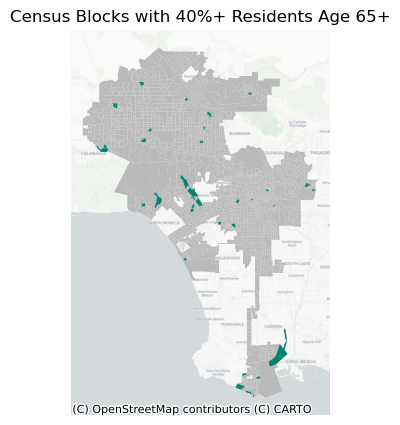

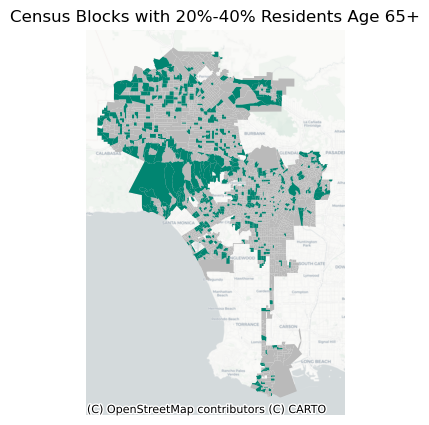

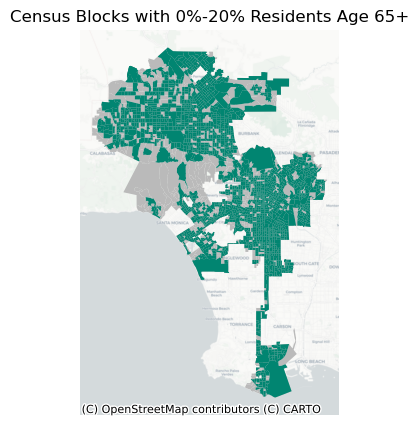

In [6]:
binary()

We can see the few tracts with the highest percentages of seniors. 

### Create a chart and map of top 10 Block Groups

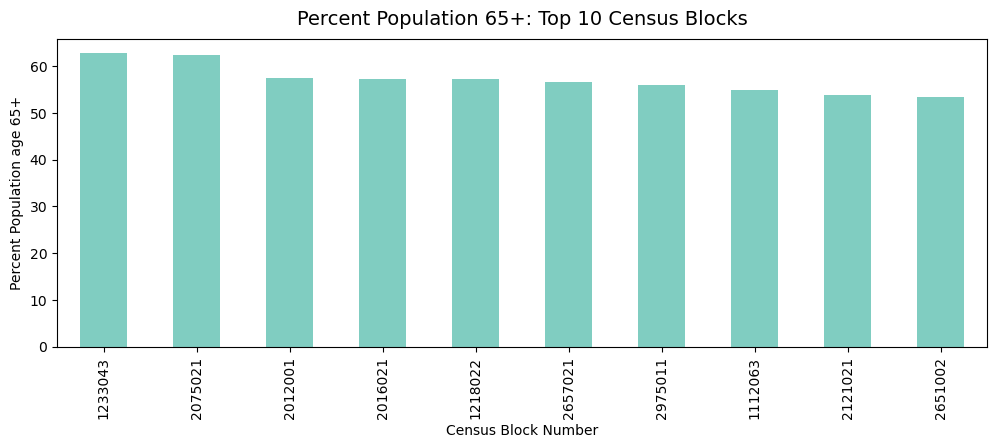

In [7]:
#plot the df
seniors.sort_values('Pct Seniors', inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(12,4))

seniors[:10].plot.bar(ax=ax,
                                      x='BG20',
                                      y='Pct Seniors',
                                      legend=False,
                                      color='#80cdc1'
                                      )
ax.set_xlabel('Census Block Number') # override x label
ax.set_ylabel('Percent Population age 65+') # override y label
ax.set_title("Percent Population 65+: Top 10 Census Blocks",fontsize=14,pad=10); # multi-line title with padding
fig.savefig('top10blockchart.png', bbox_inches='tight')

/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


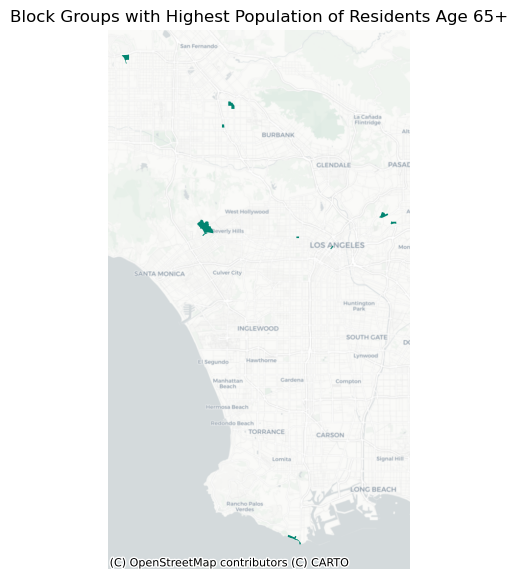

In [8]:
seniors.sort_values('Pct Seniors', inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(7,7))
seniors[:10].plot(ax=ax, 
                  column='Pct Seniors',
                  color='#018571')
ax.set_title('Block Groups with Highest Population of Residents Age 65+')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')
ax.axis('off');
fig.savefig('top10blockmap.png', bbox_inches='tight')

### Creating a Seniors Basemap by Neighborhood in addition to the Block Group data
We will examine the seniors data on the block group and neighborhood level. 

In [9]:
# Import neighborhood boundaries directly from LA GeoHub.
neighborhoods=gpd.read_file(
    'https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson').to_crs('epsg:6423').rename(columns={'name' : 'neighborhood'})
neighborhoods = neighborhoods.to_crs(4326) #converting to the projection of our Seniors data

Steps: 

1. Group by neighborhood and sum the other columns
2. Fix the percentages that were added up
3. Merge the new grouped dataframe with neighborhoods data to get the Geometry column back 

In [10]:
#group by neighborhood and add up the other columns
neighborhood_seniors = seniors.groupby(['neighborhood']).sum(numeric_only=True).reset_index()

#fix the percentage colums
neighborhood_seniors['Pct Seniors']=(neighborhood_seniors['Total Senior Pop']/neighborhood_seniors['Total Pop'])*100

#merge to neighborhoods data to get the geometry column back
neighborhood_seniors=pd.merge(neighborhoods,neighborhood_seniors,how="left", 
                              on=['neighborhood'])

Now we should have a dataframe that shows our seniors data on the neighborhood level. Create a plot of the highest percentages of senior population. This chart is more useful than our original census block plot, as neighborhoods are more recognizable. 

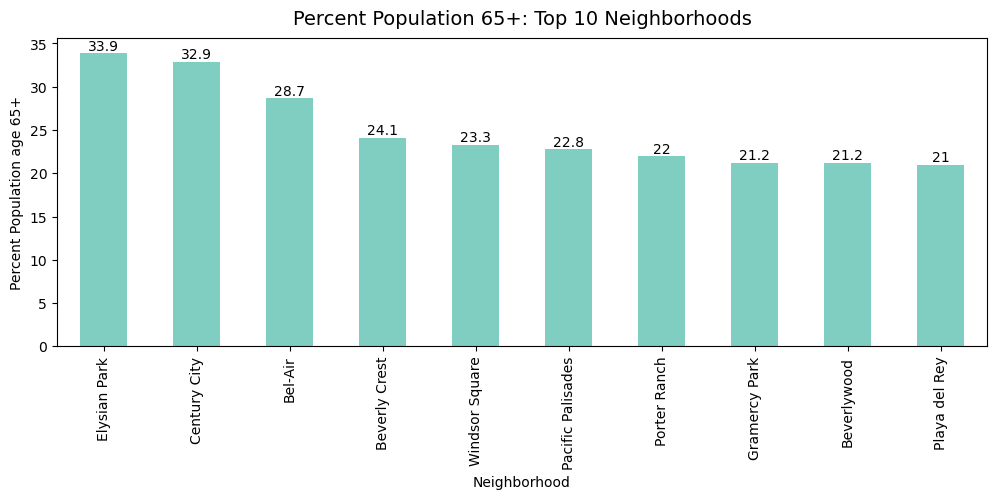

In [11]:
#plot the df
neighborhood_seniors.sort_values('Pct Seniors', inplace=True, ascending=False) #sort to see top 10
neighborhood_seniors['Pct Seniors'] = round(neighborhood_seniors['Pct Seniors'], 1) #round to one decimal place for bar labels
fig, ax = plt.subplots(figsize=(12,4))

neighborhood_seniors[:10].plot.bar(ax=ax,
                                      x='neighborhood',
                                      y='Pct Seniors',
                                      legend=False,
                                      color='#80cdc1'
                                      )
ax.bar_label(ax.containers[0], label_type='edge')
ax.set_xlabel('Neighborhood') # override x label
ax.set_ylabel('Percent Population age 65+') # override y label
ax.set_title("Percent Population 65+: Top 10 Neighborhoods",fontsize=14,pad=10); # multi-line title with padding
fig.savefig('top10neighb.png', bbox_inches='tight')

Elysian Park is the neighborhood with the highest percentage of seniors age 65+. 

Now we will create a map of the top 10 neighborhoods for additional clarity. 

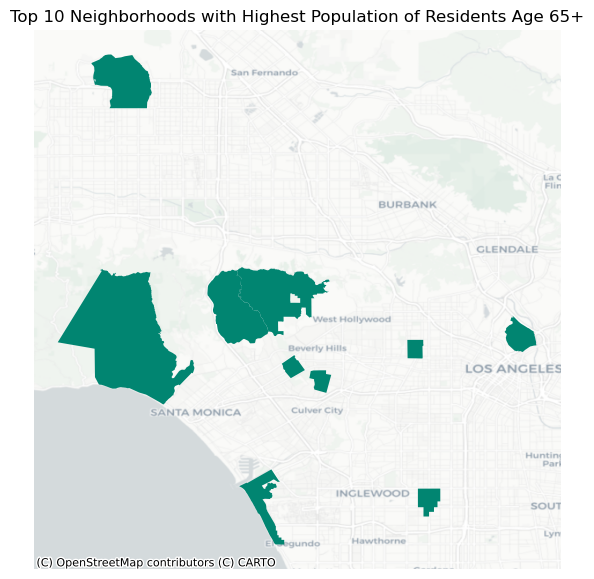

In [12]:
fig, ax = plt.subplots(figsize=(7,7))
neighborhood_seniors[:10].plot(ax=ax, 
                              color='#018571')
ax.set_title('Top 10 Neighborhoods with Highest Population of Residents Age 65+')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=4326)
ax.axis('off');
#fig.savefig('top10neighbmap.png', bbox_inches='tight')

Now we have maps of the top 10 block groups and the top 10 neighborhoods. 

# Metro Micro

The Metro Micro zones represent areas that already have good access to grocery stores for seniors, as they allow seniors to access transit without walking far to or from their destination or a transit stop. The purpose of our project is to determine where the gaps in transit are across the city, so we must account for Metro Micro zones. In essence, we want to identify potential areas for additional Metro Micro expansion. 
To begin: import our metro micro geojson created in week 4.

In [13]:
micro = gpd.read_file('data/micro.geojson')
micro.sample(5)

name                                           geometry
2  Highland Park Eagle Rock  POLYGON Z ((-118.16957 34.11194 0.00000, -118....
4   North Hollywood/Burbank  POLYGON Z ((-118.34073 34.14307 0.00000, -118....
3                LAX Update  POLYGON Z ((-118.44440 33.96200 0.00000, -118....
1            MOD - El Monte  POLYGON Z ((-118.08420 34.10368 0.00000, -118....
0         Watts Willowbrook  POLYGON Z ((-118.26535 33.95297 0.00000, -118....

# 

Map the metro micro zones with folium

In [14]:
m = folium.Map(location=[34.1,-118.3], 
               zoom_start = 10.45,
               tiles='CartoDB positron', 
               attribution='CartoDB')
#plot polygons
for _, r in micro.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': '#a6611a', "color": "#018571", 'weight': 1.5})
    folium.Popup(r['name']).add_to(geo_j)
    geo_j.add_to(m)
m

In [15]:
m.save('metromicro.html')

### Part 2: Where do Seniors Lack Access to a Vehicle in Los Angeles?

First, we read in the geojson created in the Prep Notebook, which contains information about vehicle ownership for all block groups in the City of Los Angeles.

In [16]:
vehicle_access=gpd.read_file('vehicle_access.geojson')

We are interested in vehicle ownership rates for the City of LA, so we will calcualte stats across the block groups.

In [17]:
# Calculate sum across all block groups (results in a series) and then convert that series to a dataframe.
city_totals=vehicle_access.sum(numeric_only=True).to_frame().transpose()

# Recalculate percentages.
city_totals['Pct Households Without a Vehicle']=(city_totals['Total No Vehicle']/city_totals['Total HH'])*100
city_totals['Pct Senior-Headed Households Without a Vehicle']=(city_totals['Senior No Vehicle']/city_totals['Senior HH'])*100

# Inspect results.
city_totals

Total HH  Senior HH  Total No Vehicle  Senior No Vehicle  \
0  1385427.0   287185.0          161724.0            58193.0   

   Pct Households Without a Vehicle  \
0                         11.673224   

   Pct Senior-Headed Households Without a Vehicle  
0                                       20.263245

We can see that seniors are almost twice as likely to lack access to a household vehicle. We will make a bar chart so that this information can be displayed visually in presentations.

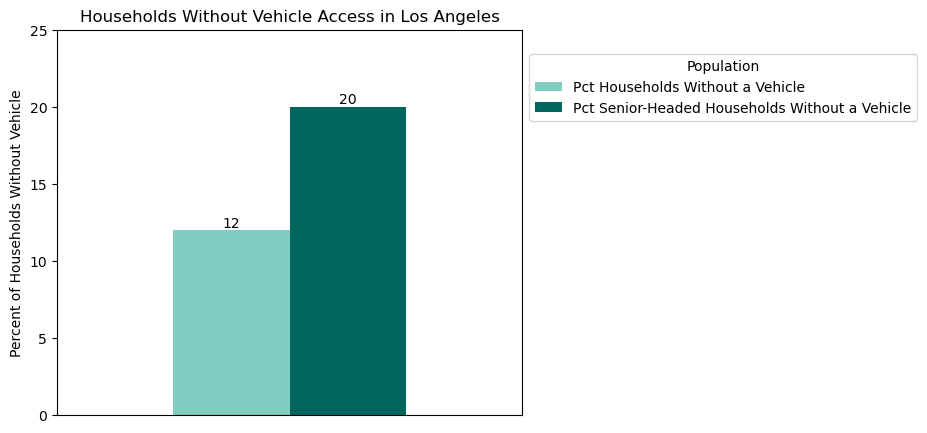

In [18]:
# Create a dataframe for chart with just rounded percentages (so that they can be displayed).
city_bar=city_totals[['Pct Households Without a Vehicle', 'Pct Senior-Headed Households Without a Vehicle']].round()

# Start plot.
fig, ax = plt.subplots(figsize=(6,5))

# Plot data and label the two bars with their values.
ax = city_bar.plot(ax=ax, kind='bar', color=['#80cdc1','#01665e'], legend=True)
ax.bar_label(ax.containers[0], label_type='edge')
ax.bar_label(ax.containers[1], label_type='edge')

# Adjust x-axis so it doesn't have a subtitle or ticks.
plt.xlabel(None)
ax.set_xticks([])

# Ajust y-axis so that it has desired subtitle and ticks.
plt.ylabel("Percent of Households Without Vehicle")
ax.set_yticks((0,5,10,15,20,25))

#Adjust table and legend.
plt.title("Households Without Vehicle Access in Los Angeles")
plt.legend(loc='center left', bbox_to_anchor=(1, .85), title='Population')

plt.show()

We want to understand how vehicle access varies by geography. To do this, we will aggregate data by neighborhood and then recalculate car ownership rates.

In [23]:
# Import neighborhood boundaries directly from LA GeoHub.
neighborhoods=gpd.read_file(
    'https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson').to_crs('epsg:6423').rename(columns={'name' : 'neighborhood'})

In [24]:
# Create a new dataframe with totals for each neighborhood that sums up all relevant columns.
vehicles_by_neighborhood = vehicle_access.groupby(['neighborhood']).sum(numeric_only=True).reset_index()

# Recalculate percentages.
vehicles_by_neighborhood['Pct Households Without a Vehicle']=(vehicles_by_neighborhood['Total No Vehicle']/vehicles_by_neighborhood['Total HH'])*100
vehicles_by_neighborhood['Pct Senior-Headed Households Without a Vehicle']=(vehicles_by_neighborhood['Senior No Vehicle']/vehicles_by_neighborhood['Senior HH'])*100

# Finally, we have to add back in the geometry column from the original neighborhood geodataframe.
vehicles_by_neighborhood=pd.merge(neighborhoods[['neighborhood','geometry']],vehicles_by_neighborhood,how="left", on=['neighborhood'])

# See how this table looks.
vehicles_by_neighborhood.head()

neighborhood                                           geometry  \
0         Adams-Normandie  POLYGON ((1972233.388 559643.685, 1971938.035 ...   
1                  Arleta  POLYGON ((1959244.309 584850.051, 1959257.540 ...   
2       Arlington Heights  POLYGON ((1970582.552 561395.372, 1970757.410 ...   
3         Atwater Village  MULTIPOLYGON (((1974284.934 572493.221, 197428...   
4  Baldwin Hills/Crenshaw  POLYGON ((1966656.952 558331.179, 1966727.113 ...   

   Total HH  Senior HH  Total No Vehicle  Senior No Vehicle  \
0      5141        915               960                294   
1      7950       1791               337                164   
2      6220       1151               940                256   
3      4782       1207               279                126   
4     14391       3609              2323                835   

   Pct Households Without a Vehicle  \
0                         18.673410   
1                          4.238994   
2                         15.112540   
3                          5.834379   
4                         16.142033   

   Pct Senior-Headed Households Without a Vehicle  
0                                       32.131148  
1                                        9.156896  
2                                       22.241529  
3                                       10.439105  
4                                       23.136603

We will create a choropleth map by neighborhood to summarize vehicle access by neighborhood.

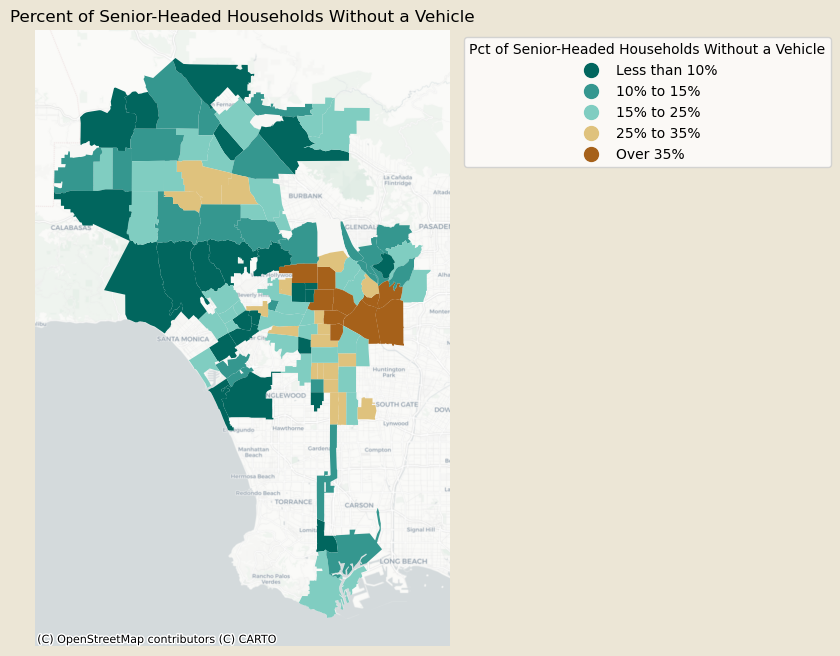

In [122]:
# Add in colors based on the percent of households that don't have a car for mapping.
for index, row in vehicles_by_neighborhood.iterrows():
    if vehicles_by_neighborhood.loc[index, 'Pct Senior-Headed Households Without a Vehicle'] < 10:
        vehicles_by_neighborhood.loc[index, 'colors'] = '#01665e'
    elif vehicles_by_neighborhood.loc[index, 'Pct Senior-Headed Households Without a Vehicle'] < 15:
        vehicles_by_neighborhood.loc[index, 'colors'] = '#35978f'
    elif vehicles_by_neighborhood.loc[index, 'Pct Senior-Headed Households Without a Vehicle'] < 25:
        vehicles_by_neighborhood.loc[index, 'colors'] = '#80cdc1'
    elif vehicles_by_neighborhood.loc[index, 'Pct Senior-Headed Households Without a Vehicle'] < 35:
        vehicles_by_neighborhood.loc[index, 'colors'] = '#dfc27d'
    elif vehicles_by_neighborhood.loc[index, 'Pct Senior-Headed Households Without a Vehicle'] <= 100:
        vehicles_by_neighborhood.loc[index, 'colors'] = '#a6611a'
    else:
        vehicles_by_neighborhood.loc[index, 'colors'] = '#f7f7f5'
# Map neighborhoods.
fig,ax = plt.subplots(figsize=(6,8))
vehicles_by_neighborhood.plot(ax=ax,color=vehicles_by_neighborhood['colors'])

legend_elements = [(Line2D([0], [0], marker='o', color='#01665e', linestyle='',label='Less than 10%', markersize=10)),
                  (Line2D([0], [0], marker='o', color='#35978f', linestyle='',label='10% to 15%', markersize=10)),
                  (Line2D([0], [0], marker='o', color='#80cdc1', linestyle='',label='15% to 25%', markersize=10)),
                  (Line2D([0], [0], marker='o', color='#dfc27d', linestyle='',label='25% to 35%', markersize=10)),
                  (Line2D([0], [0], marker='o', color='#a6611a', linestyle='',label='Over 35%', markersize=10))]
fig.legend(handles=legend_elements,loc='center left', bbox_to_anchor=(.87,.79), title="Pct of Senior-Headed Households Without a Vehicle")


ax.axis('off')
ax.set_title('Percent of Senior-Headed Households Without a Vehicle')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')
fig.patch.set_facecolor('#ECE6D6')
plt.savefig('vehicle_map.png',bbox_inches="tight")

Now, we'll create a bar graph to drill down on the 10 neighborhoods where senior-headed households are the least likely to own a vehicle.

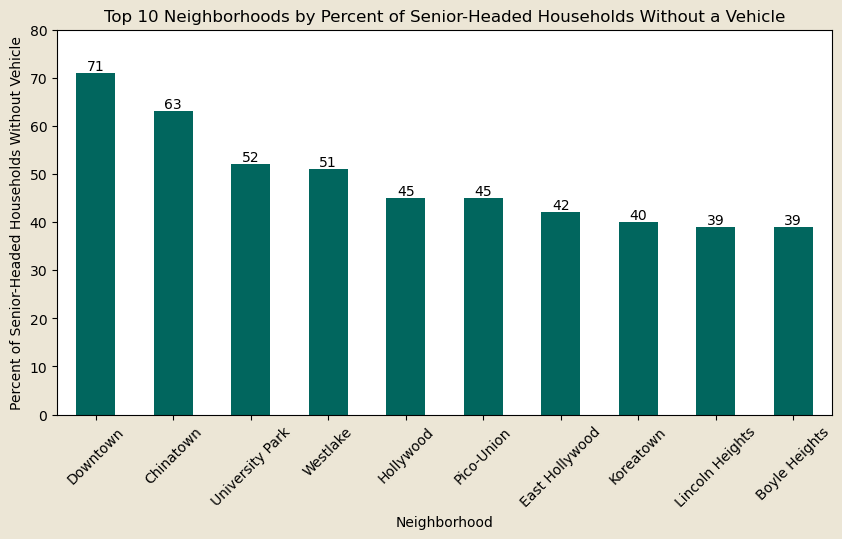

In [121]:
# Create a dataframe for chart with sorted, rounded percentages (so that they can be displayed).
neighborhood_bar=vehicles_by_neighborhood[['neighborhood','Pct Senior-Headed Households Without a Vehicle']].round().sort_values(by=['Pct Senior-Headed Households Without a Vehicle'],ascending=False)

# Start plot.
fig, ax = plt.subplots(figsize=(10,5))
ax = neighborhood_bar[:10].plot(ax=ax, kind='bar', x='neighborhood', y= 'Pct Senior-Headed Households Without a Vehicle', color=['#01665e'], legend=False)
ax.bar_label(ax.containers[0], label_type='edge')

# Adjust x-axis.
plt.xlabel("Neighborhood")
plt.xticks(rotation=45)

# Ajust y-axis.
plt.ylabel("Percent of Senior-Headed Households Without Vehicle")
ax.set_yticks((0,10,20,30,40,50,60,70,80))

#Adjust table and legend.
plt.title("Top 10 Neighborhoods by Percent of Senior-Headed Households Without a Vehicle")

fig.patch.set_facecolor('#ECE6D6')
plt.savefig('vehicle_chart.png',bbox_inches="tight")
plt.show()

From this chart, we learn that the neighborhoods where seniors are concentrated in Central and East Los Angeles.

### Part 3: What does grocery store access look like in Los Angeles?

To understand where grocery stores are located in the City of Los Angeles, we used data from the USDA on the  locations of authorized SNAP retailers . The majority of locations that accept EBT are small convenient stores, so we used just the chain supermarkets (e.g., Ralphs, Smart and Final) from this dataset. We would prefer to include small independent grocery retailers in further analysis, because these smaller retailers are an important source of fresh and healthy food, particularly for immigrant populations. However, there was no way to systematically differentiate between independent convenient stores and independent grocery stores, and the vast majority of locations in the raw data fall into the former category.   
<br>First, we read in the geojson created in the [Prep Notebook](https://github.com/lucybriggs12/snakeemoji/blob/7f0fee81acd93bdcb55dc1bb5f69d088fdcf0100/Group%20Assignments/Week%2008/Prep_Notebook.ipynb), which contains information about the grocery stores. For initial analysis, we want to analyze just grocery chains within the municipal border.

In [27]:
# Read file.
grocery_chains=gpd.read_file('chain_with_neighborhood.geojson')

# Create new geodataframe with just chains within the City of LA.
chain_with_neighborhood=grocery_chains[grocery_chains['neighborhood'].notna()].copy().reset_index().drop(columns=['index'])

We want to make a map of grocery stores in Los Angeles categorized by their chain. However, there are too many supermarket chains to map them with every chain as its own category, so I will create a new dataframe for the primary purpose of mapping. This new dataframe will contain a column (chain_map) that contains the chain's name for very big chains, and the chain type for smaller chains. First, I determine what the top 5 chains are.

In [28]:
# Display fist five items in a new dataframe with counts of each chain.
top_chains = chain_with_neighborhood.value_counts(['chain_name']).reset_index(name='count').iloc[:5]
top_chains

chain_name  count
0         Ralphs     43
1         Target     30
2  Smart & Final     30
3   Trader Joe's     22
4    Food 4 Less     21

Now I can use this information to create my new chain_map categories.

In [29]:
#Create new geodataframe for map.
chain_map=chain_with_neighborhood.copy()

# Create new variable that defaults to the chain type.
chain_map['chain_map'] = chain_map['chain_type']

# Replace value with the chain's name for Top 5 Chains.
chain_map.loc[chain_map['chain_name'] == "Ralphs", 'chain_map'] = "Ralphs"
chain_map.loc[chain_map['chain_name'] == "Smart & Final", 'chain_map'] = "Smart & Final"
chain_map.loc[chain_map['chain_name'] == "Target", 'chain_map'] = "Target"
chain_map.loc[chain_map['chain_name'] == "Trader Joe's", 'chain_map'] = "Trader Joe's"
chain_map.loc[chain_map['chain_name'] == "Food 4 Less", 'chain_map'] = "Food 4 Less"

# See how many stores there are in each mapping category.
chainmap_counts = chain_map.value_counts(['chain_map']).reset_index(name='count')
chainmap_counts

chain_map  count
0  Standard chain (e.g. Ralphs, Trader Joe's)    102
1                                      Ralphs     43
2         Upscale (e.g. Whole Foods, Sprouts)     38
3                               Smart & Final     30
4                                      Target     30
5  Discount (e.g. Smart & Final, Food 4 Less)     25
6                                Trader Joe's     22
7                                 Food 4 Less     21
8     Department store (e.g. Target, Walmart)      5

I notice that by pulling the Targets out separately, there aren't enough department stores to map as a category, so I'll fold these into standard chains.

In [30]:
chain_map.loc[chain_map['chain_name'] == "Walmart", 'chain_map'] = "Standard chain (e.g. Ralphs, Trader Joe's)"

Finally, I must rename my categories to remove references to chains that have been pulled out.

In [31]:
chain_map.loc[chain_map['chain_map'] == "Standard chain (e.g. Ralphs, Trader Joe's)", 'chain_map'] = "Other Standard Chain (e.g. Vons)"
chain_map.loc[chain_map['chain_map'] == "Discount (e.g. Smart & Final, Food 4 Less)", 'chain_map'] = "Other Discount Chain (e.g. Mother's Nutritional Center)"
chain_map.loc[chain_map['chain_map'] == "Upscale (e.g. Whole Foods, Sprouts)", 'chain_map'] = "Upscale Chain (e.g. Whole Foods)"

# See how many stores there are in each mapping category.
chainmap_counts = chain_map.value_counts(['chain_map']).reset_index(name='count')
chainmap_counts

chain_map  count
0                   Other Standard Chain (e.g. Vons)    107
1                                             Ralphs     43
2                   Upscale Chain (e.g. Whole Foods)     38
3                                      Smart & Final     30
4                                             Target     30
5  Other Discount Chain (e.g. Mother's Nutritiona...     25
6                                       Trader Joe's     22
7                                        Food 4 Less     21

Now I can create an interactive map that has the locations of each supermarket chain grocery store in the City of LA. This map helps us understand the spatial distribution of chains overall and _which_ chains are in which areas.

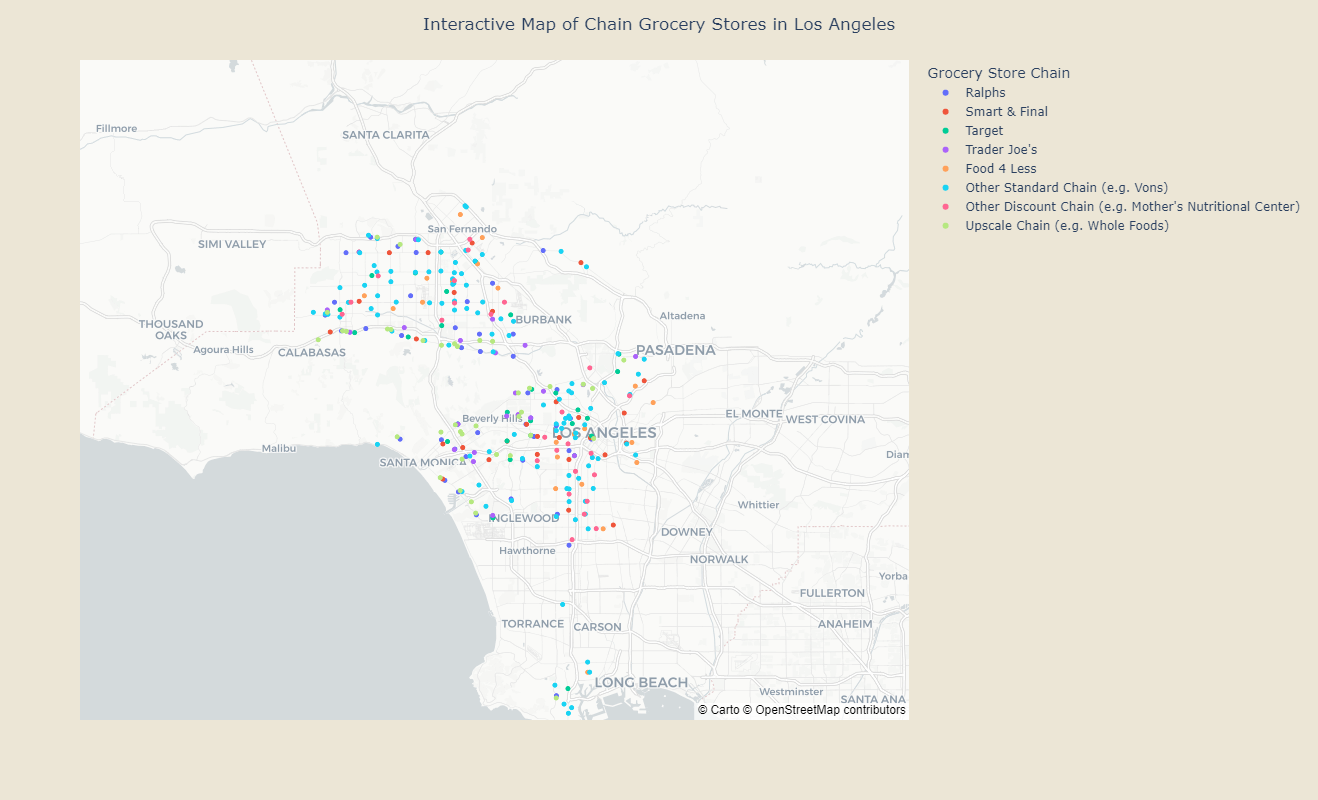

In [88]:
# Create an order column with the desired order (in the legend I want first the top 5 chains in descending order of prevalence and then the chain groups)
chain_map.loc[chain_map['chain_map'] == "Ralphs", 'chain_map_order'] = 1
chain_map.loc[chain_map['chain_map'] == "Smart & Final", 'chain_map_order'] = 2
chain_map.loc[chain_map['chain_map'] == "Target", 'chain_map_order'] = 3
chain_map.loc[chain_map['chain_map'] == "Trader Joe's", 'chain_map_order'] = 4
chain_map.loc[chain_map['chain_map'] == "Food 4 Less", 'chain_map_order'] = 5
chain_map.loc[chain_map['chain_map'] == "Other Standard Chain (e.g. Vons)", 'chain_map_order'] = 6
chain_map.loc[chain_map['chain_map'] == "Other Discount Chain (e.g. Mother's Nutritional Center)", 'chain_map_order'] = 7
chain_map.loc[chain_map['chain_map'] == "Upscale Chain (e.g. Whole Foods)", 'chain_map_order'] = 8

# Sort by my new order column.
chain_map=chain_map.sort_values('chain_map_order')

# Create an interactive map where markers are colored by the name of the chain.
fig = px.scatter_mapbox(chain_map,
                        lat='Latitude',
                        lon='Longitude',
                        color='chain_map',
                        mapbox_style="carto-positron",
                        labels={
                            'chain_map':'Grocery Store Chain',
                        })

# Update layout with desired size, zoom, title, etc.
# Chart specifically must be wider to accomodate the longer names in the legend.
fig.update_layout(
    width = 950,
    height = 800,
    mapbox_style="carto-positron",
    mapbox_zoom=9,
    title = "Interactive Map of Chain Grocery Stores in Los Angeles",
    title_x=0.5,
    plot_bgcolor='#ECE6D6',
    paper_bgcolor='#ECE6D6')
fig.write_html('chain_map.html')
fig.show()

Exploring this map helps us understand geographic trends in how residential segregation and food affordability are related. While "Discount Chains" are concentrated in South LA, "Upscale Chains" are generally concentrated in West LA and along the 101. Although price range was outside the scope of this analysis, these trends would be interesting to explore further in future research.

Now we turn our attention to the question of which areas are within walking distance of a grocery store. First, we'll read in the geojsons that we'll need, with the most notable one being the dataframe of walksheds created in the  [Prep Notebook](https://github.com/lucybriggs12/snakeemoji/blob/7f0fee81acd93bdcb55dc1bb5f69d088fdcf0100/Group%20Assignments/Week%2008/Prep_Notebook.ipynb).

In [33]:
# Read the geojson from the prep notebook that has walkshed geometries.
walksheds=gpd.read_file('grocery_walksheds.geojson')

# Read the geojson from the prep notebook that has census block group geometries.
bg_geometries=gpd.read_file('bg_geometries.geojson')

# Import LA City boundary directly from Los Angeles GeoHub. 
cityboundary_proj=gpd.read_file("https://maps.lacity.org/lahub/rest/services/Boundaries/MapServer/7/query?outFields=*&where=1%3D1&f=geojson").to_crs('epsg:6423')

# Import neighborhood boundaries directly from LA GeoHub.
neighborhoods=gpd.read_file(
    'https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson').to_crs('epsg:6423').rename(columns={'name' : 'neighborhood'})

# Read the geojson from the prep notebook that has population access.
senior_grocery=gpd.read_file('senior_grocery.geojson')

The geoprocessing occured in our Prep Notebook, but our methodology is described in the following diagram.

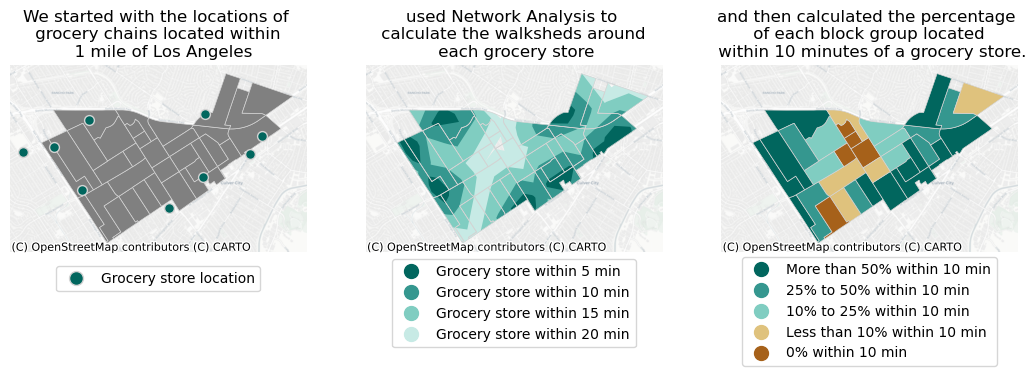

In [123]:
# Get all block groups within the neighborhood.
neighborhood_bgs=senior_grocery[senior_grocery['neighborhood']=='Palms']
# Overlay this new geographic extent with the walksheds to get just walksheds within the neighborhoods.    
neighborhood_walkshed=gpd.overlay(walksheds,neighborhood_bgs,how='intersection', keep_geom_type=None, make_valid=True)
# Clip point data to get just points within 1140 meters of the neighborhoods.
neighborhood_bgs_buffer=neighborhood_bgs.buffer(570)
neighborhood_stores=gpd.clip(grocery_chains,neighborhood_bgs_buffer)

# Map all three subplots.
fig, ax = plt.subplots(1, 3, figsize=(13, 12))
neighborhood_bgs.plot(ax=ax[0],color="grey",edgecolor='lightgrey',lw=0.5)
neighborhood_stores.plot(ax=ax[0],marker='o',color='#01665e', edgecolor='lightgrey',markersize=50)
neighborhood_stores.plot(ax=ax[1],alpha=0)
neighborhood_walkshed.plot(ax=ax[1],color=neighborhood_walkshed['colors_1'])
neighborhood_bgs.plot(ax=ax[1],color="None",edgecolor='lightgrey',lw=0.5)
neighborhood_stores.plot(ax=ax[2],alpha=0)
neighborhood_bgs.plot(ax=ax[2],color=neighborhood_bgs['colors'],edgecolor='lightgrey',lw=0.5)


# Create custom legend
from matplotlib.lines import Line2D
legend_elements1 = [(Line2D([0], [0], marker='o', color='#01665e', linestyle='', markeredgecolor='lightgrey', label='Grocery store location', markersize=10))]
ax[0].legend(handles=legend_elements1,loc='lower center', bbox_to_anchor=(0.5,-0.25))
ax[0].axis("off")
ax[0].set_title("We started with the locations of \n grocery chains located within \n  1 mile of Los Angeles")
ctx.add_basemap(ax=ax[0], source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

legend_elements2 = [(Line2D([0], [0], marker='o', color='#01665e', linestyle='',label='Grocery store within 5 min', markersize=10)),
                      (Line2D([0], [0], marker='o', color='#35978f', linestyle='',label='Grocery store within 10 min', markersize=10)),
                      (Line2D([0], [0], marker='o', color='#80cdc1', linestyle='',label='Grocery store within 15 min', markersize=10)),
                      (Line2D([0], [0], marker='o', color='#c7eae5', linestyle='',label='Grocery store within 20 min', markersize=10))]
ax[1].legend(handles=legend_elements2,loc='lower center', bbox_to_anchor=(0.5,-0.55))
ax[1].axis("off")
ax[1].set_title("used Network Analysis to \n calculate the walksheds around \n each grocery store")
ctx.add_basemap(ax=ax[1], source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

legend_elements3 = [(Line2D([0], [0], marker='o', color='#01665e', linestyle='',label='More than 50% within 10 min', markersize=10)),
                      (Line2D([0], [0], marker='o', color='#35978f', linestyle='',label='25% to 50% within 10 min', markersize=10)),
                      (Line2D([0], [0], marker='o', color='#80cdc1', linestyle='',label='10% to 25% within 10 min', markersize=10)),
                      (Line2D([0], [0], marker='o', color='#dfc27d', linestyle='',label='Less than 10% within 10 min', markersize=10)),
                      (Line2D([0], [0], marker='o', color='#a6611a', linestyle='',label='0% within 10 min', markersize=10))]
ax[2].legend(handles=legend_elements3,loc='lower center', bbox_to_anchor=(0.5,-0.65))
ax[2].axis("off")
ax[2].set_title("and then calculated the percentage \n of each block group located \n within 10 minutes of a grocery store.")
ctx.add_basemap(ax=ax[2], source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

plt.savefig('grocery_walk_methodology.png',bbox_inches="tight",transparent=True)
plt.show()

We can use this information to do some basic calculations about how likely Seniors are to live within walking distance of a grocery chain, and whether they have worse (or better) acess than the general population of Los Angeles. To do these calculations, we created a new table that sums up all of the data across all block groups.

In [36]:
# Sum up all of the data for all of the block groups in each category.
senior_sums = senior_grocery.sum(numeric_only=True)
senior_sums=pd.DataFrame(senior_sums).transpose()
senior_sums['pct_5_min']=round(100*senior_sums['all_5_min']/senior_sums['Total_Pop'])
senior_sums['pct_10_min']=round(100*senior_sums['all_10_min']/senior_sums['Total_Pop'])
senior_sums['pct_15_min']=round(100*senior_sums['all_15_min']/senior_sums['Total_Pop'])
senior_sums['pct_none']=round(100*senior_sums['all_none']/senior_sums['Total_Pop'])
senior_sums['seniors_pct_5_min']=round(100*senior_sums['seniors_5_min']/senior_sums['Total Senior Pop'])
senior_sums['seniors_pct_10_min']=round(100*senior_sums['seniors_10_min']/senior_sums['Total Senior Pop'])
senior_sums['seniors_pct_15_min']=round(100*senior_sums['seniors_15_min']/senior_sums['Total Senior Pop'])
senior_sums['seniors_none']=round(100*senior_sums['seniors_none']/senior_sums['Total Senior Pop'])


senior_sums_all=senior_sums[['pct_5_min','pct_10_min','pct_15_min','pct_none']]
senior_sums_all['population']='All Residents'
senior_sums_seniors=senior_sums[['seniors_pct_5_min','seniors_pct_10_min','seniors_pct_15_min','seniors_none']].rename(columns={
    'seniors_pct_5_min':'pct_5_min', 'seniors_pct_10_min':'pct_10_min', 'seniors_pct_15_min':'pct_15_min', 'seniors_none':'pct_none'})
senior_sums_seniors['population']='Seniors'
grocery_table=pd.concat([senior_sums_all,senior_sums_seniors])
grocery_table=grocery_table.reset_index().drop(columns=['index','pct_15_min'])

# Take a look at our table.
grocery_table

/tmp/ipykernel_5234/1330527046.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



pct_5_min  pct_10_min  pct_none     population
0        4.0        20.0      80.0  All Residents
1        4.0        18.0      82.0        Seniors

Now we can create our bar plot.

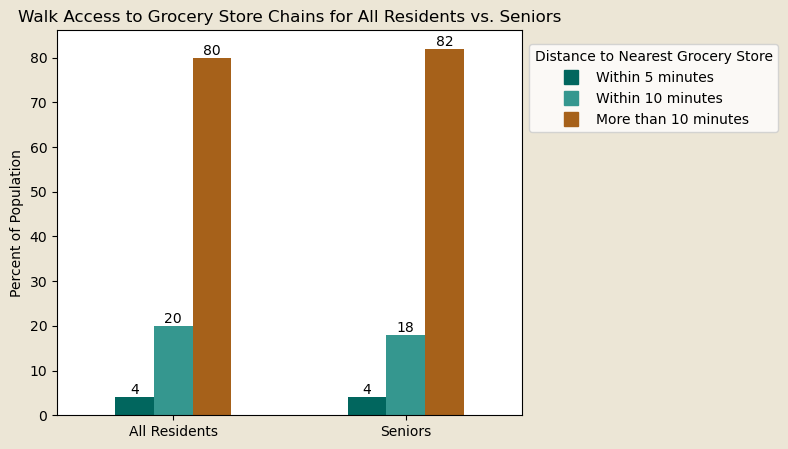

In [73]:
# Now I plot the pivot table.
fig, ax = plt.subplots(figsize=(6,5))

ax = grocery_table.plot(ax=ax, kind='bar',x='population', color=['#01665e','#35978f','#a6611a'] , legend=True)
ax.bar_label(ax.containers[0], label_type='edge')
ax.bar_label(ax.containers[1], label_type='edge')
ax.bar_label(ax.containers[2], label_type='edge')

# Adjust x-axis.
plt.xlabel(None)
plt.xticks(rotation=0)

# Ajust y-axis.
plt.ylabel("Percent of Population")

#Adjust table and legend.
plt.title("Walk Access to Grocery Store Chains for All Residents vs. Seniors")

# build custom legend
legend_elements = [(Line2D([0], [0], marker='s', color='#01665e', linestyle='',label='Within 5 minutes', markersize=10)),
                  (Line2D([0], [0], marker='s', color='#35978f', linestyle='',label='Within 10 minutes', markersize=10)),
                  (Line2D([0], [0], marker='s', color='#a6611a', linestyle='',label='More than 10 minutes', markersize=10))]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, .85), title='Distance to Nearest Grocery Store')

fig.patch.set_facecolor('#ECE6D6')
plt.savefig('grocery_walkable_plot.png',bbox_inches="tight"bbox_inches="tight",transparent=True)
plt.show()

We can see from this chart that Seniors are more likely to live in a census block group that does not have a walkable grocery store (82% compared to 80%).

We also want to understand which neighborhoods have particularly low access for seniors, so we'll aggregate our data by neighborhood.

In [38]:
# Create a new dataframe with totals for each neighborhood that sums up all relevant columns.
grocery_by_neighborhood = senior_grocery.groupby(['neighborhood']).sum(numeric_only=True).reset_index()

# Recalculate percentages.
grocery_by_neighborhood['pct_snr_5_min']=(grocery_by_neighborhood['seniors_5_min']/grocery_by_neighborhood['Total Senior Pop'])
grocery_by_neighborhood['pct_snr_10_min']=(grocery_by_neighborhood['seniors_10_min']/grocery_by_neighborhood['Total Senior Pop'])
grocery_by_neighborhood['pct_snr_15_min']=(grocery_by_neighborhood['seniors_15_min']/grocery_by_neighborhood['Total Senior Pop'])
grocery_by_neighborhood['pct_snr_none']=(grocery_by_neighborhood['seniors_none']/grocery_by_neighborhood['Total Senior Pop'])

# Finally, we have to add back in the geometry column from the original neighborhood geodataframe.
grocery_by_neighborhood=pd.merge(neighborhoods[['neighborhood','geometry']],grocery_by_neighborhood,how="left", on=['neighborhood'])

# Keep just necessary columns.
grocery_by_neighborhood=grocery_by_neighborhood[['neighborhood','geometry','pct_snr_5_min','pct_snr_10_min','pct_snr_15_min','pct_snr_none']]

# Add in neighborhood colors for mapping.
for index, row in grocery_by_neighborhood.iterrows():
    if grocery_by_neighborhood.loc[index, 'pct_snr_10_min'] ==0:
        grocery_by_neighborhood.loc[index, 'colors'] = '#a6611a'
    elif grocery_by_neighborhood.loc[index, 'pct_snr_10_min'] < .10:
        grocery_by_neighborhood.loc[index, 'colors'] = '#dfc27d'
    elif grocery_by_neighborhood.loc[index, 'pct_snr_10_min'] < .25:
        grocery_by_neighborhood.loc[index, 'colors'] = '#80cdc1'
    elif grocery_by_neighborhood.loc[index, 'pct_snr_10_min'] < .50:
        grocery_by_neighborhood.loc[index, 'colors'] = '#35978f'
    elif grocery_by_neighborhood.loc[index, 'pct_snr_10_min'] <= 1:
        grocery_by_neighborhood.loc[index, 'colors'] = '#01665e'
    else:
        grocery_by_neighborhood.loc[index, 'colors'] = '#f7f7f5'

# See how this table looks.
grocery_by_neighborhood.sort_values('pct_snr_none',ascending=True).head(5)

neighborhood                                           geometry  \
52         Koreatown  POLYGON ((1973426.406 562358.370, 1973427.701 ...   
49         Hollywood  POLYGON ((1969734.109 567209.707, 1969839.499 ...   
43   Harvard Heights  POLYGON ((1972240.553 560032.451, 1972223.927 ...   
106         Westlake  POLYGON ((1976080.190 561472.084, 1976010.254 ...   
80          Sawtelle  POLYGON ((1959009.539 560789.257, 1959806.166 ...   

     pct_snr_5_min  pct_snr_10_min  pct_snr_15_min  pct_snr_none   colors  
52        0.147267        0.544597        0.795689      0.455403  #01665e  
49        0.097670        0.457952        0.773800      0.542048  #35978f  
43        0.089863        0.456966        0.878488      0.543034  #35978f  
106       0.083579        0.440776        0.897137      0.559224  #35978f  
80        0.104077        0.399226        0.716128      0.600774  #35978f

Now we can visualize how access varies by block group _and_ neighborhood.

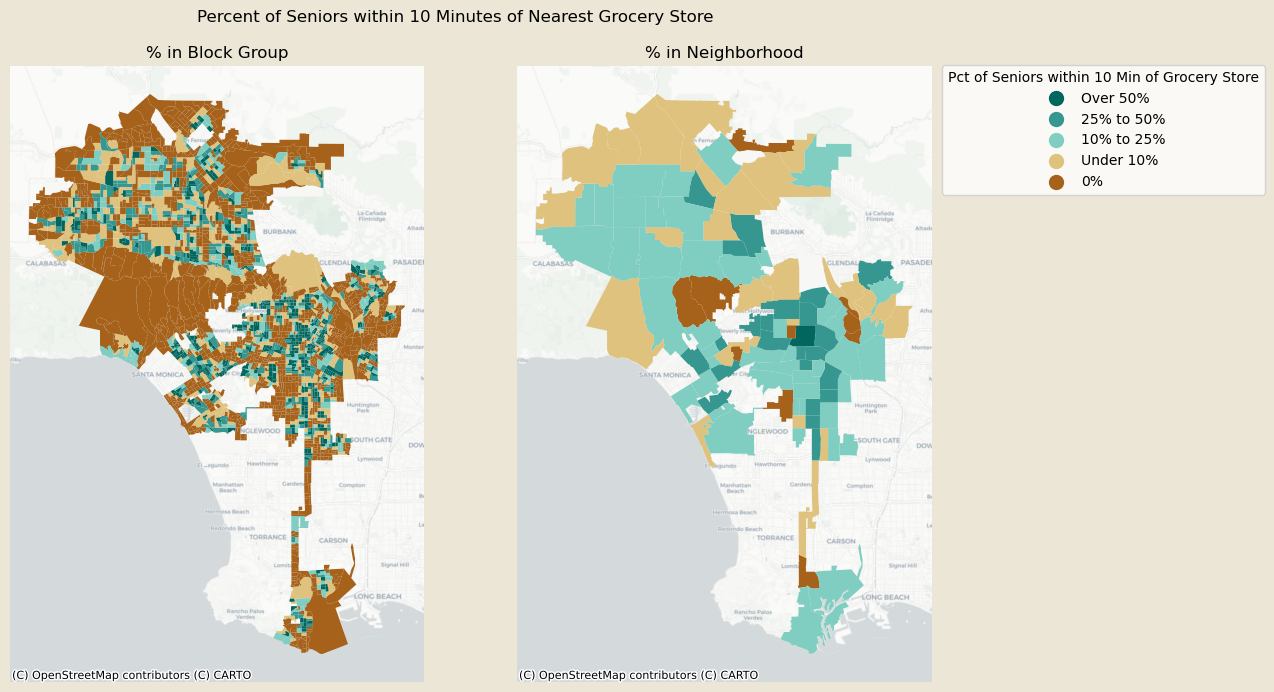

In [72]:
# Map all three subplots.
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

senior_grocery.plot(ax=ax[0],color=senior_grocery['colors'])
ax[0].axis("off")
ax[0].set_title("% in Block Group")
ctx.add_basemap(ax=ax[0], source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

# spatial lag map on the right
grocery_by_neighborhood.plot(ax=ax[1],color=grocery_by_neighborhood['colors'])
ax[1].axis("off")
ax[1].set_title("% in Neighborhood")
ctx.add_basemap(ax=ax[1], source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

# build custom legend
legend_elements = [(Line2D([0], [0], marker='o', color='#01665e', linestyle='',label='Over 50%', markersize=10)),
                  (Line2D([0], [0], marker='o', color='#35978f', linestyle='',label='25% to 50%', markersize=10)),
                  (Line2D([0], [0], marker='o', color='#80cdc1', linestyle='',label='10% to 25%', markersize=10)),
                  (Line2D([0], [0], marker='o', color='#dfc27d', linestyle='',label='Under 10%', markersize=10)),
                  (Line2D([0], [0], marker='o', color='#a6611a', linestyle='',label='0%', markersize=10))]

fig.legend(handles=legend_elements,loc='center left', bbox_to_anchor=(.9,.8), title="Pct of Seniors within 10 Min of Grocery Store")
fig.suptitle('Percent of Seniors within 10 Minutes of Nearest Grocery Store',x=0.5,y=.95)
fig.patch.set_facecolor('#ECE6D6')
plt.savefig('grocery_walkable_map.png',bbox_inches="tight")
plt.show()

### Part 4: What is the distribution of public transit like in LA? 
In this section, we will look at density of transit stops in the city of Los Angeles, and how that relates to where senior residents are living. We aim to identify whether/where there areas where there are high numbers of senior residents, and comparatively low density of transit options.

First we import data on neighborhood boundaries, transit stop locations, transity stop density, and senior population. The transit stop density and location files are compilations of data developed for the midterm, and saved as files for future use.

In [40]:
# Reset senior basemap.
seniors = gpd.read_file('data/Seniors_Basemap.geojson')

In [41]:
#read in transit stop data and create dataframes

#Spatial data for public transit stops in City of LA
transit_stops = gpd.read_file('data/transit_stops.geojson')
#Information on number of public transit stops per 
transit_density = pd.read_csv('data/transit_stopcount.csv')
lowtransitdensebg = gpd.read_file('data/lowdensityblockgroups.geojson')
hightransitdensebg= gpd.read_file('data/highdensityblockgroups.geojson')

#read in LA Times Neighborhood Boundaries 
neighborhoods = gpd.read_file('data/LA_Times_Neighborhood_Boundaries.geojson')

### Map of Transit Stop Locations and Senior Density

First, we look at where public transit stops are located in LA, and how that compares to where seniors are most densely located.

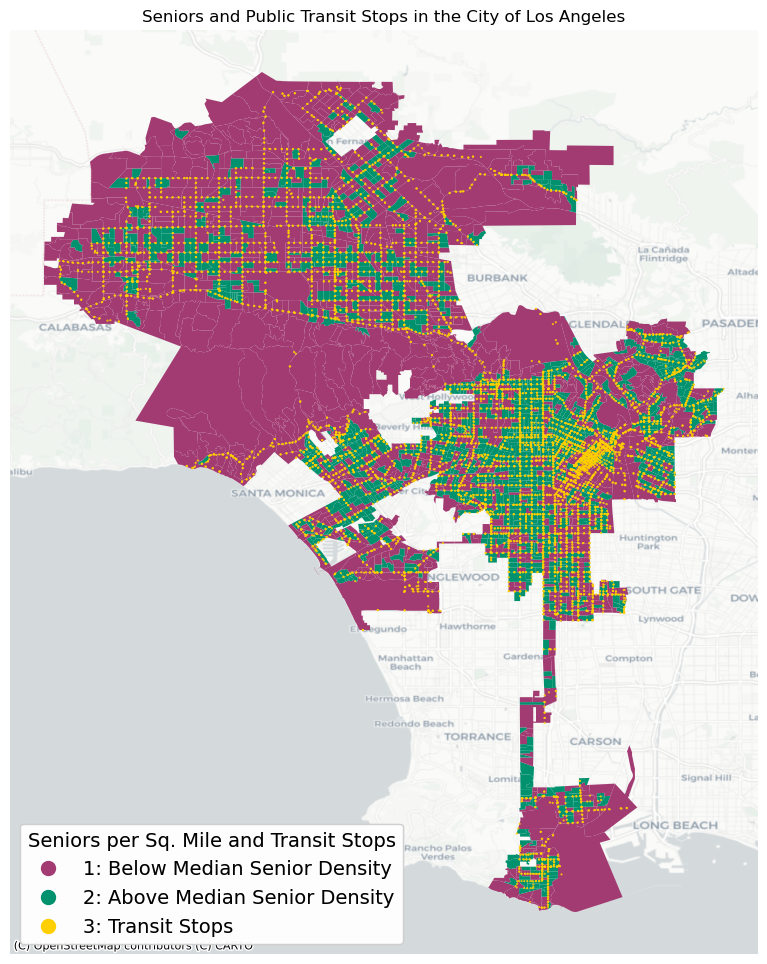

In [42]:
# I am going to have to create a manual legend since I have multiple layers, so I will first create a color dictionary.
color_dict = {'1: Below Median Senior Density': '#A23B72',
 '2: Above Median Senior Density': '#00916E',
 '3: Transit Stops': '#FFCF00'}

# Now I create a "colors" column in each separate dataframe that denotes the color I want things to show up as.

seniors.loc[seniors["Pop Density"] < 135.000000, "colors"]= '#A23B72' 
seniors.loc[seniors["Pop Density"] >= 135.000000, "colors"]= '#00916E' 
transit_stops["colors"] = '#FFCF00'

#Plot Bus Stops and Metro Stops on top of Senior Population Density
fig,ax = plt.subplots(figsize=(12,12))
ax1=seniors.plot(ax=ax,zorder=1,color=seniors['colors'])

#plot LA metro bus stops
ax2=transit_stops.plot(ax=ax, zorder=2, marker='.',markersize=1,legend=True,color=transit_stops['colors'])
                                                                                                
# Add manual legend.
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
leg_points = ax.legend(custom_points, color_dict.keys(), title="Seniors per Sq. Mile and Transit Stops",fontsize = 14)
leg_points.get_title().set_fontsize('14') 
ax.add_artist(leg_points)


#Format plot.
ax.axis('off')
ax.set_title('Seniors and Public Transit Stops in the City of Los Angeles')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=4326)

### Map of Density of Transit Stops

Next, we look at density of transit stops to get a better spatial metric. The following map shows block groups in the top and bottom quartiles (highest and lowest) of transit stops/block group. This can help provide a visual of areas that might be good to focus in on for futher analysis.

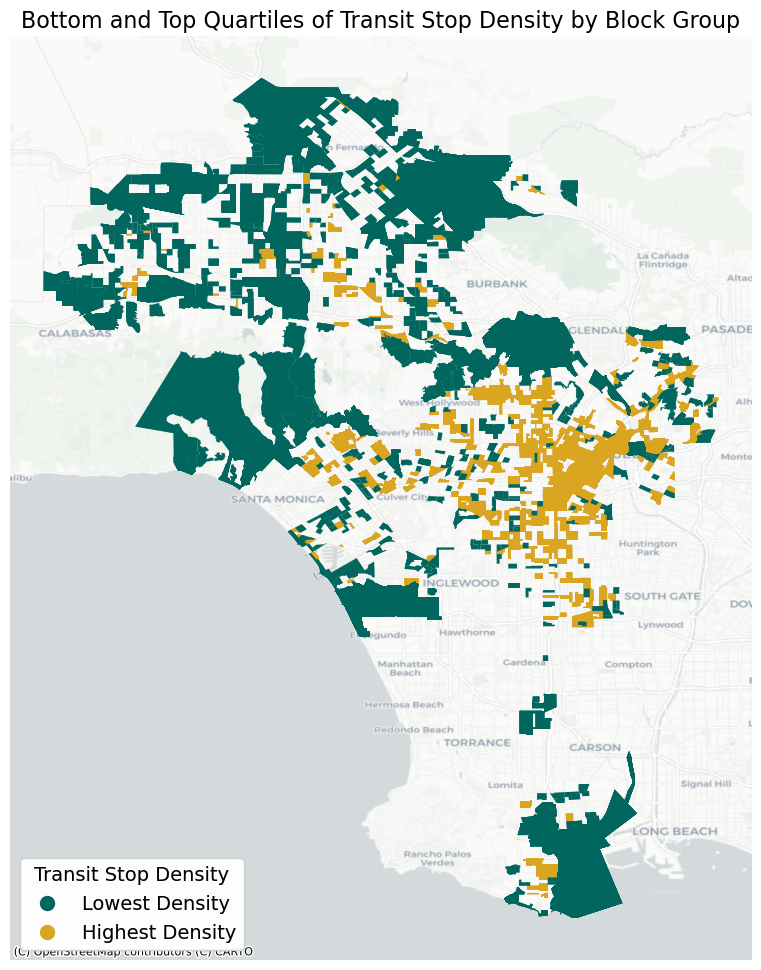

In [43]:
# Add manual legend
color_dict = {'Lowest Density': '#01665e',
 'Highest Density': '#DAA520'}

# Now I create a "colors" column in each separate dataframe that denotes the color I want things to show up as.
lowtransitdensebg["colors"] = '#01665e'
hightransitdensebg["colors"] = '#DAA520'

# Now I create my actual map with the three geodataframes added in the appropriate order (zorder).
fig,ax = plt.subplots(figsize=(12,12))
lowtransitdensebg.plot(ax=ax, zorder=2, color=lowtransitdensebg['colors'])
hightransitdensebg.plot(ax=ax, zorder=1, color=hightransitdensebg['colors'])

# Add manual legend.
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
leg_points = ax.legend(custom_points, color_dict.keys(),loc='lower left', title="Transit Stop Density", fontsize = 14)
leg_points.get_title().set_fontsize('14') 
ax.add_artist(leg_points)

#Format plot.
ax.axis('off')
ax.set_title('Bottom and Top Quartiles of Transit Stop Density by Block Group',fontsize = 16)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=4326)

### Scaling Up to Neighborhoods

Since we hope to pick several neighborhoods to focus in on for more analysis, it is helpful to connect this information to neighborhood boundaries.

We will join the transit_stops geodataframe to the LA neighborhood boundaries.

In [44]:
#spatial join of transit stop locations and neighborhood boundaries
transit_stops_nbrhood = gpd.sjoin(transit_stops, neighborhoods)
#display
transit_stops_nbrhood.sample(1)

stopid            stopname                     geometry   colors  \
7923   7115  Victory / Bellaire  POINT (-118.40921 34.18683)  #FFCF00   

      index_right  OBJECTID         name  
7923           94        95  Valley Glen

In [45]:
#Use valuecounts to get the number of unique stops per neighborhood
transit_nbrhood_count= transit_stops_nbrhood.value_counts(['name']).reset_index(name='stop_count')
#display statistics 
transit_nbrhood_count.describe()

stop_count
count  113.000000
mean    90.398230
std     94.149533
min      2.000000
25%     37.000000
50%     71.000000
75%    117.000000
max    850.000000

In [46]:
#Create dataframe of lowest quartile of # of transit stops/neighborhood.
low25_nbhd = transit_nbrhood_count[transit_nbrhood_count["stop_count"] < 37.000000]
#rename columns for plotting
low25_nbhd = low25_nbhd.rename(columns={'stop_count': 'Number of Public Transit Stops', 'name': 'Neighborhood'})

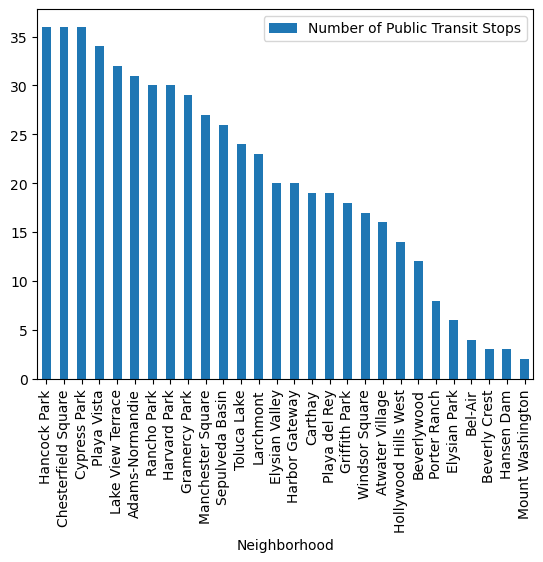

In [47]:
#Plot bar graph
ax = low25_nbhd.plot.bar(x='Neighborhood', y='Number of Public Transit Stops', rot=90)

Calculate transit stops per square mile at the neighborhood level.

In [48]:
# Open file with square milage of neighborhoods.
neighborhood_geometries=gpd.read_file('neighborhood_geometries.geojson')

# Join areas to transit counts.
transit_nbrhood_count=transit_nbrhood_count.rename(columns={'name':'neighborhood'})
transit_nbrhood_count=pd.merge(transit_nbrhood_count,neighborhood_geometries,how='left',on=['neighborhood'])
transit_nbrhood_count['stop_density']=transit_nbrhood_count['stop_count']/transit_nbrhood_count['official_area']
transit_nbrhood_count=transit_nbrhood_count.sort_values('stop_density')

### Neighborhood Prioritization

#### Calculating Percentiles Per Neighborhood.

In [49]:
# Calculate percentiles.
neighborhood_seniors['Senior_Percentile']=(neighborhood_seniors['Pct Seniors'].rank())/(max(neighborhood_seniors['Pct Seniors'].rank()))*100
vehicles_by_neighborhood['Vehicle_Percentile']=(vehicles_by_neighborhood['Pct Senior-Headed Households Without a Vehicle'].rank())/(max(vehicles_by_neighborhood['Pct Senior-Headed Households Without a Vehicle'].rank()))*100
grocery_by_neighborhood['Grocery_Percentile']=(grocery_by_neighborhood['pct_snr_none'].rank())/(max(grocery_by_neighborhood['pct_snr_none'].rank()))*100
transit_nbrhood_count['Stop_Percentile']=(transit_nbrhood_count['stop_density'].rank(ascending=False))/(max(transit_nbrhood_count['stop_density'].rank(ascending=False)))*100

# Merge into one dataframe.
neighborhood_priority=pd.merge(neighborhood_seniors[['neighborhood','geometry','Senior_Percentile']],vehicles_by_neighborhood[['neighborhood','Vehicle_Percentile']],on=['neighborhood'],how='left')
neighborhood_priority=pd.merge(neighborhood_priority,grocery_by_neighborhood[['neighborhood','Grocery_Percentile']],on=['neighborhood'],how='left')
neighborhood_priority=pd.merge(neighborhood_priority,transit_nbrhood_count[['neighborhood','Stop_Percentile','pop_density']],on=['neighborhood'],how='left')

# Average scores across variables. 
neighborhood_priority['Priority_Index']=(neighborhood_priority['Senior_Percentile']+neighborhood_priority['Vehicle_Percentile']+neighborhood_priority['Grocery_Percentile']+neighborhood_priority['Stop_Percentile'])/4

# Get top 10. 
neighborhood_priority=neighborhood_priority.sort_values(by=['Priority_Index'],ascending=False)
neighborhood_priority.iloc[0:10]

neighborhood                                           geometry  \
0        Elysian Park  POLYGON ((-118.24246 34.09391, -118.24057 34.0...   
3       Beverly Crest  POLYGON ((-118.42910 34.07920, -118.42929 34.0...   
2             Bel-Air  POLYGON ((-118.46165 34.13077, -118.46077 34.1...   
14            Tujunga  POLYGON ((-118.26682 34.23068, -118.26882 34.2...   
20  Lake View Terrace  POLYGON ((-118.38741 34.29824, -118.38740 34.2...   
68    Sepulveda Basin  POLYGON ((-118.47144 34.16192, -118.47241 34.1...   
17       Shadow Hills  MULTIPOLYGON (((-118.27059 34.23274, -118.2698...   
18         West Hills  POLYGON ((-118.60375 34.23324, -118.60300 34.2...   
15            Tarzana  POLYGON ((-118.52729 34.17083, -118.52724 34.1...   
6        Porter Ranch  POLYGON ((-118.52951 34.25727, -118.55873 34.2...   

    Senior_Percentile  Vehicle_Percentile  Grocery_Percentile  \
0          100.000000           90.990991          100.000000   
3           97.345133            9.009009          100.000000   
2           98.230088            8.108108          100.000000   
14          88.053097           64.864865           59.154930   
20          82.300885           32.432432          100.000000   
68          39.823009           74.774775           92.018779   
17          84.955752           10.810811           93.896714   
18          84.070796           39.639640           76.056338   
15          86.725664           45.045045           61.971831   
6           94.690265            1.801802           86.384977   

    Stop_Percentile  pop_density  Priority_Index  
0         91.150442    75.129934       95.535358  
3        100.000000  1197.102369       76.588535  
2         99.115044   978.507432       76.363310  
14        90.265487  2434.674615       75.584595  
20        84.955752  3808.639360       74.922267  
68        84.070796    64.759082       72.671840  
17        93.805310  1138.369042       70.867147  
18        83.185841  4875.781518       70.738154  
15        88.495575  4203.370552       70.559529  
6         96.460177  4321.605184       69.834305

In [50]:
def priorityplt(num):
    fig,ax = plt.subplots(figsize=(8,8))
    micro.plot(ax=ax,color='grey',alpha=.5,edgecolor='black',lw=1)
    neighborhood_priority.iloc[0:num].plot(ax=ax,color='#01665e',edgecolor='#80cdc1',lw=1)
    ax.axis('off')
    ax.set_title('Top '+str(num)+' Highest Scoring Neighborhoods')
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=4326)

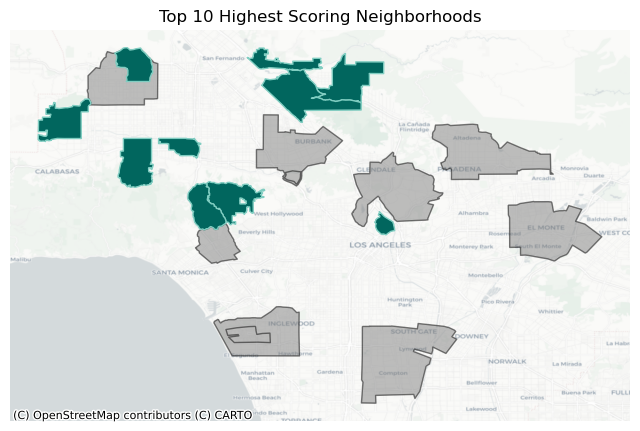

In [51]:
priorityplt(10)

## Screening for Urban Areas

Many of the areas identified in the above priority index are dominated by greenspace/parks rather than residents, so density of grocery stores a metric that doesn't make sense.  Because of this, we need to screen for urban areas, which are defined by the census as areas with at least 1000 people per square mile. 

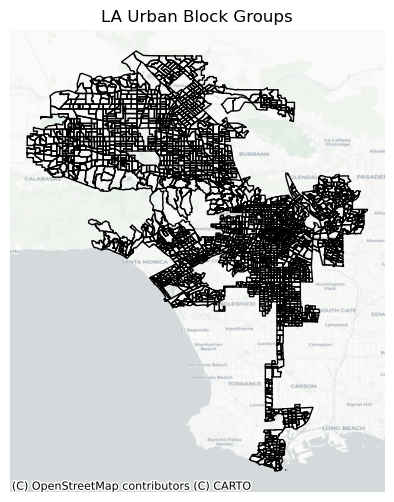

In [52]:
#Read in information on population density per square mile
pop_density = bg_geometries.rename(columns={'pop_density':'Total Pop Density'}).to_crs(crs=4326)

#create dataframe of urban areas (at least 1000 people per square mile)
urban = pop_density.loc[pop_density['Total Pop Density']>1000]

#Plot urban areas
fig, ax = plt.subplots(figsize=(5,6))
urban.plot(ax=ax, 
        color='none', 
          edgecolor = 'k',
          linewidth = 1)

# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('LA Urban Block Groups')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=4326)

Next, I will spatially join our neighborhood priority index with urban block groups to understand where they overlap.

In [53]:
# join of dataframes
neighborhood_priority_urban = pd.merge(urban,neighborhood_priority,how='left',on=['neighborhood'])
#display joined dataframe
neighborhood_priority_urban.head(5)

BG20  Total_Pop  Total Pop Density  official_area     neighborhood  \
0  9800171     1075.0           1162.828       0.022800        Brentwood   
1  3201022     1934.0           5660.926       0.003002          Pacoima   
2  3017024     1079.0           9679.230       0.005682  Atwater Village   
3  2976023     1148.0          13965.220       0.082204        San Pedro   
4  2976022     1241.0          11796.650       0.105199        San Pedro   

                                          geometry_x   colors  \
0  MULTIPOLYGON (((-118.46673 34.06771, -118.4653...  #a6611a   
1  MULTIPOLYGON (((-118.42347 34.29632, -118.4214...  #a6611a   
2  POLYGON ((-118.27557 34.15317, -118.27556 34.1...  #a6611a   
3  POLYGON ((-118.29162 33.71970, -118.29162 33.7...  #a6611a   
4  POLYGON ((-118.29162 33.71516, -118.29065 33.7...  #a6611a   

                                          geometry_y  Senior_Percentile  \
0  POLYGON ((-118.49014 34.13096, -118.49009 34.1...          88.053097   
1  POLYGON ((-118.41131 34.28981, -118.40915 34.2...          27.433628   
2  MULTIPOLYGON (((-118.27886 34.15321, -118.2788...          83.185841   
3  MULTIPOLYGON (((-118.28845 33.75438, -118.2885...          68.141593   
4  MULTIPOLYGON (((-118.28845 33.75438, -118.2885...          68.141593   

   Vehicle_Percentile  Grocery_Percentile  Stop_Percentile   pop_density  \
0           14.414414           58.215962        86.725664   2507.106907   
1           54.954955           25.352113        67.256637  11597.951685   
2           25.225225           71.361502        82.300885   8257.667583   
3           48.648649           46.948357        73.451327   5669.624442   
4           48.648649           46.948357        73.451327   5669.624442   

   Priority_Index  
0       61.852284  
1       43.749333  
2       65.518363  
3       59.297481  
4       59.297481

Now we have a dataframe with only urban areas, but we need to condense block group infomation to the neighborhood level.

<AxesSubplot: >

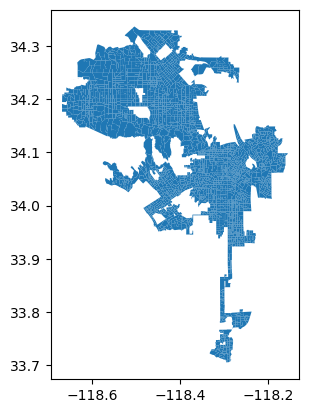

In [54]:
neighborhood_priority_urban=neighborhood_priority_urban.set_geometry('geometry_x')
neighborhood_priority_urban.plot()

In [55]:
#use dissolve function to get neighborhood level dataset 
neighborhood_priority_urban = neighborhood_priority_urban.dissolve(by='neighborhood', aggfunc='mean').reset_index()
#sort new dataset by index ranking
neighborhood_priority_urban=neighborhood_priority_urban.sort_values(by=['Priority_Index'],ascending=False)

#Now we're gonna manually throw out the three richest neighborhoods which are super outliers (over 2x median hh income)
neighborhood_priority_urban=neighborhood_priority_urban[neighborhood_priority_urban['neighborhood']!='Bel-Air']
neighborhood_priority_urban=neighborhood_priority_urban[neighborhood_priority_urban['neighborhood']!='Beverly Crest']
neighborhood_priority_urban=neighborhood_priority_urban[neighborhood_priority_urban['neighborhood']!='Pacific Palisades']

#look at top 10 priority neighboorhoods
neighborhood_priority_urban.iloc[0:10]

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1676: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



neighborhood                                         geometry_x  \
88                Tujunga  POLYGON ((-118.28968 34.24908, -118.28983 34.2...   
50      Lake View Terrace  POLYGON ((-118.37018 34.28190, -118.36988 34.2...   
78           Shadow Hills  MULTIPOLYGON (((-118.34419 34.21410, -118.3441...   
100            West Hills  POLYGON ((-118.66144 34.18950, -118.66131 34.1...   
86                Tarzana  POLYGON ((-118.54312 34.12704, -118.54370 34.1...   
73           Porter Ranch  POLYGON ((-118.55787 34.25926, -118.55781 34.2...   
45   Hollywood Hills West  POLYGON ((-118.39468 34.09677, -118.39256 34.0...   
8             Beverlywood  POLYGON ((-118.39055 34.04787, -118.39046 34.0...   
84                Sunland  POLYGON ((-118.30706 34.25240, -118.30760 34.2...   
34          Granada Hills  POLYGON ((-118.52892 34.26285, -118.52879 34.2...   

       Total_Pop  Total Pop Density  official_area  Senior_Percentile  \
88   1482.529412       10717.835765       0.204879          88.053097   
50   1962.857143        7230.187571       0.548979          82.300885   
78   1922.400000        4105.078600       0.693979          84.955752   
100  1656.120000        5974.801360       0.332780          84.070796   
86   1499.120000       12539.501680       0.356647          86.725664   
73   1375.941176        4577.428353       0.318387          94.690265   
45   1182.615385        4018.487385       0.396953          81.415929   
8     980.000000        7214.159000       0.133761          93.362832   
84   1308.076923        8514.623000       0.221563          77.876106   
34   1537.166667        8441.501333       0.290057          76.991150   

     Vehicle_Percentile  Grocery_Percentile  Stop_Percentile  pop_density  \
88            64.864865           59.154930        90.265487  2434.674615   
50            32.432432          100.000000        84.955752  3808.639360   
78            10.810811           93.896714        93.805310  1138.369042   
100           39.639640           76.056338        83.185841  4875.781518   
86            45.045045           61.971831        88.495575  4203.370552   
73             1.801802           86.384977        96.460177  4321.605184   
45            18.918919           79.812207        94.690265  2979.235795   
8              9.909910          100.000000        69.911504  7326.491471   
84            46.846847           70.422535        76.991150  5903.869963   
34            30.630631           69.483568        87.610619  3844.297120   

     Priority_Index  
88        75.584595  
50        74.922267  
78        70.867147  
100       70.738154  
86        70.559529  
73        69.834305  
45        68.709330  
8         68.296062  
84        68.034160  
34        66.178992

In [56]:
#plot
def priorityplturban(num):
    fig,ax = plt.subplots(figsize=(8,8))
    micro.plot(ax=ax,color='grey',alpha=.5,edgecolor='black',lw=1)
    neighborhood_priority_urban.iloc[0:num].plot(ax=ax,color='#01665e',edgecolor='#80cdc1',lw=1)
    ax.axis('off')
    ax.set_title('Top '+str(num)+' Highest Scoring Neighborhoods')
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=4326)

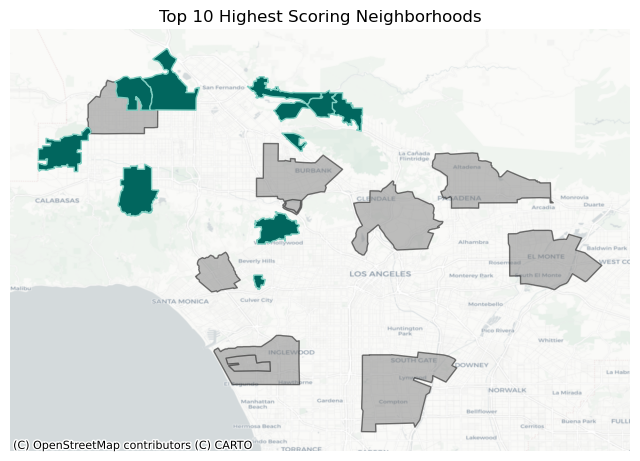

In [57]:
priorityplturban(10)

#### Potential Method 3: z-scores at the block group level

In [58]:
# Senior population
seniors_index=gpd.read_file('Percent_Senior_Basemap.geojson').to_crs('epsg:6423')
seniors_index=seniors_index[['BG20','Total Pop','Pct Seniors']]
seniors_index.sample(3)

# Senior vehicle access
vehicle_index=gpd.read_file('vehicle_access.geojson')
vehicle_index=vehicle_index[['BG20','Pct Senior-Headed Households Without a Vehicle']]

# Grocery store access.
grocery_index=senior_grocery[['BG20','pct_none','geometry']]
grocery_index['pct_none']=grocery_index['pct_none']*100

# Transit stop density
transit_index=pd.read_csv('data/transit_stopcount.csv')
transit_index=transit_index[['BG20','stopdensity']]
transit_index['BG20']=transit_index['BG20'].astype(str)

# Merge
bg_priority=pd.merge(grocery_index,seniors_index,how='left',on=['BG20'])
bg_priority=pd.merge(bg_priority,vehicle_index,how='left',on=['BG20'])
bg_priority=pd.merge(bg_priority,transit_index,how='left',on=['BG20'])
bg_priority['stopdensity']=bg_priority['stopdensity'].fillna(0)
bg_priority.sample(3)
bg_priority=pd.merge(bg_priority,bg_geometries[['BG20','pop_density','official_area','neighborhood']],how='left',on=['BG20'])
bg_priority['stopdensity']=bg_priority['stopdensity'].fillna(0)
bg_priority=bg_priority[bg_priority['pop_density']>1000]

# Calculate z-scores.
from scipy import stats
bg_priority['seniors_z']=stats.zscore(bg_priority['Pct Seniors'], nan_policy='omit')
bg_priority['vehicle_z']=stats.zscore(bg_priority['Pct Senior-Headed Households Without a Vehicle'], nan_policy='omit')
bg_priority['grocery_z']=stats.zscore(bg_priority['pct_none'], nan_policy='omit')
bg_priority['transit_z']=stats.zscore(bg_priority['stopdensity'], nan_policy='omit')
bg_priority.describe()

# Average z-scores for available data.
bg_priority['Priority_Index']=(bg_priority['seniors_z']+bg_priority['vehicle_z']+bg_priority['grocery_z']+bg_priority['transit_z'])/4
bg_priority.loc[bg_priority['Pct Senior-Headed Households Without a Vehicle'].isna(), 'Priority_Index'] = (bg_priority['seniors_z']+bg_priority['grocery_z']+bg_priority['transit_z'])/3

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Maybe we want to look at spatial autocorrelation???

In [59]:
# For spatial statistics
import libpysal as lps
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(bg_priority,k=8)
# Row-standardization
wq.transform = 'r'
# create a new column for the spatial lag
bg_priority['Index_lag'] = lps.weights.lag_spatial(wq, bg_priority['Priority_Index'])

In [60]:
bg_priority['Index_lag_percentile']=(bg_priority['Index_lag'].rank())/(max(bg_priority['Index_lag'].rank()))*100

# Assign colors for plots.
for index, row in bg_priority.iterrows():
    if bg_priority.loc[index, 'Index_lag_percentile']< 20:
        bg_priority.loc[index, 'colors'] = '#8c510a'
    elif bg_priority.loc[index, 'Index_lag_percentile'] < 40:
        bg_priority.loc[index, 'colors'] = '#bf812d'
    elif bg_priority.loc[index, 'Index_lag_percentile'] < 60:
        bg_priority.loc[index, 'colors'] = '#dfc27d'
    elif bg_priority.loc[index, 'Index_lag_percentile'] < 80:
        bg_priority.loc[index, 'colors'] = '#35978f'
    else:
        bg_priority.loc[index, 'colors'] = '#01665e'

Text(0.5, 1.0, 'Priority Index - Spatial Lag')

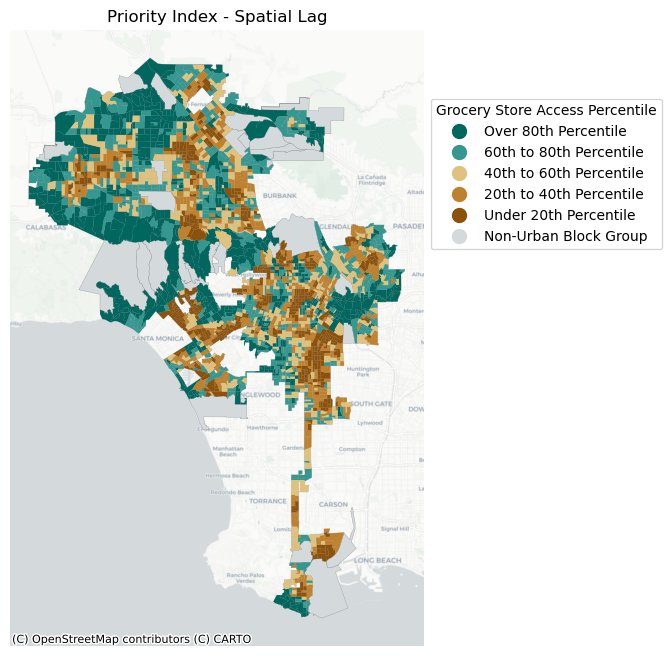

In [61]:
# Map
fig, ax = plt.subplots(figsize=(12, 8))
bg_geometries.plot(ax=ax,color='#d4dadc',edgecolor='grey',lw=0.2)
bg_priority.plot(ax=ax,color=bg_priority['colors'])

# build custom legend
legend_elements = [(Line2D([0], [0], marker='o', color='#01665e', linestyle='',label='Over 80th Percentile', markersize=10)),
                  (Line2D([0], [0], marker='o', color='#35978f', linestyle='',label='60th to 80th Percentile', markersize=10)),
                  (Line2D([0], [0], marker='o', color='#dfc27d', linestyle='',label='40th to 60th Percentile', markersize=10)),
                  (Line2D([0], [0], marker='o', color='#bf812d', linestyle='',label='20th to 40th Percentile', markersize=10)),
                  (Line2D([0], [0], marker='o', color='#8c510a', linestyle='',label='Under 20th Percentile', markersize=10)),
                  (Line2D([0], [0], marker='o', color='#d4dadc', linestyle='',label='Non-Urban Block Group', markersize=10))]
ax.legend(handles=legend_elements,loc='upper left', bbox_to_anchor=(1,.9), title="Grocery Store Access Percentile")

#Format plot.
ax.axis('off')
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')
ax.set_title('Priority Index - Spatial Lag')

Is anything "statistically significant"?

In [62]:
bg_priority=bg_priority[bg_priority['Priority_Index']<100]

In [63]:
# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(bg_priority,k=8)
# Row-standardization
wq.transform = 'r'

y = bg_priority.Priority_Index
moran = Moran(y, wq)
moran.I

# calculate local moran values
lisa = esda.moran.Moran_Local(y, wq)

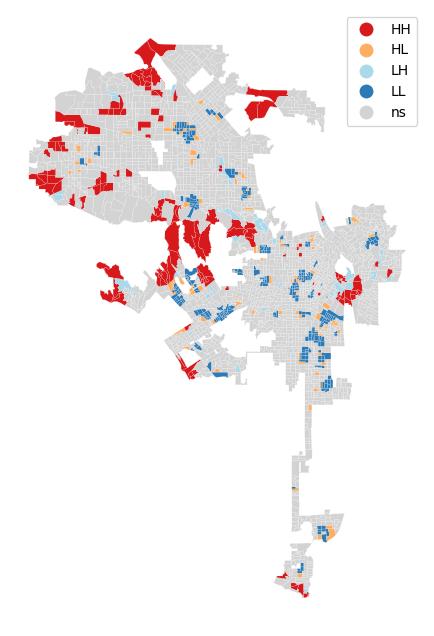

In [64]:
fig, ax = plt.subplots(figsize=(8,8))
lisa_cluster(lisa, bg_priority, p=0.05, ax=ax)
plt.show()

# Ranking neighborhoods based on what percentage of people live within a block group that is statistically significant according to our index

<AxesSubplot: >

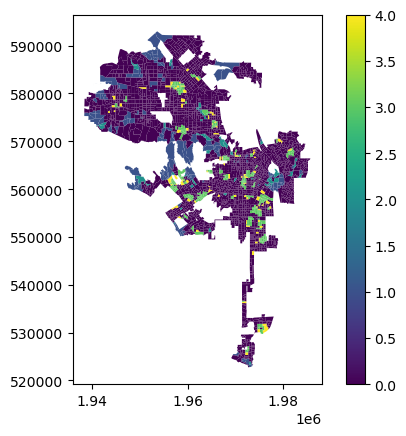

In [65]:
# First I followed this documentation (https://github.com/pysal/splot/blob/main/splot/_viz_utils.py)
# This code creates a function to return an array of cluster memberships at a given level of significance.
def moran_hot_cold_spots(moran_loc, p=0.05):
    sig = 1 * (moran_loc.p_sim < p)
    HH = 1 * (sig * moran_loc.q == 1)
    LL = 3 * (sig * moran_loc.q == 3)
    LH = 2 * (sig * moran_loc.q == 2)
    HL = 4 * (sig * moran_loc.q == 4)
    cluster = HH + LL + LH + HL
    return cluster

# Call function (results in an array).
cluster_results=moran_hot_cold_spots(lisa, p=0.05)

# Convert array to a dataframe and then merge it with the bg_priority dataframe.
lisa_df = pd.DataFrame(cluster_results,columns = ['lisa'])
bg_priority=bg_priority.reset_index().drop(columns=['index'])
bg_lisa=pd.merge(bg_priority,lisa_df,left_index=True, right_index=True)

# Plot to see if this worked.
bg_lisa.plot(column='lisa',legend=True)

In [66]:
#Focus on HH areas, which are represented by a LISA value of 1.
bg_lisa_HH = bg_lisa.loc[bg_lisa['lisa']==1]

# Sum to get total area of HH block groups in each neighborhood. 
bg_lisa_neighborhood = bg_lisa_HH.groupby(['neighborhood']).sum(numeric_only=True).reset_index()
bg_lisa_neighborhood=bg_lisa_neighborhood[['neighborhood','official_area']].rename(columns={'official_area':'HH_area'})

# Merge this neighborhood sum onto the full neighborhood dataframe. 
bg_lisa_neighborhood=pd.merge(neighborhood_geometries,bg_lisa_neighborhood,how='left')

# Calculate what percentage of each neighborhood is covered by HH block groups.
bg_lisa_neighborhood['HH_area']=bg_lisa_neighborhood['HH_area'].fillna(0)
bg_lisa_neighborhood['HH_pct']=bg_lisa_neighborhood['HH_area']/bg_lisa_neighborhood['official_area']

<AxesSubplot: >

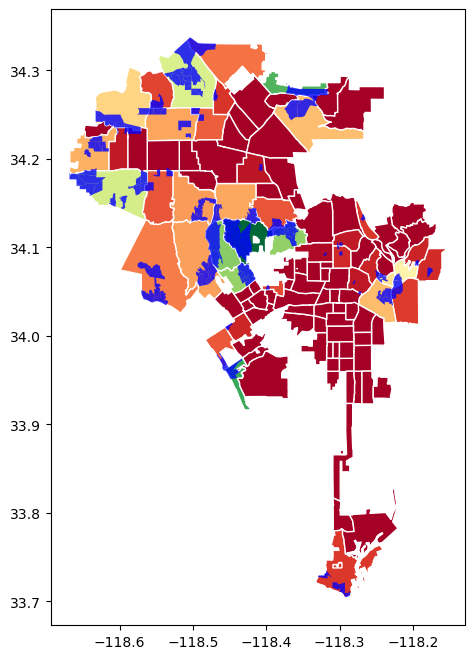

In [67]:
# Convert to same CRS so that we can plot them together.
bg_lisa_HH=bg_lisa_HH.to_crs('4326')
bg_lisa_neighborhood=bg_lisa_neighborhood.to_crs('4326')

# Plot neighborhoods based on what percentage are covered by HH block groups with the HH block groups overlaid.
fig, ax = plt.subplots(figsize=(8, 8))
bg_lisa_neighborhood.plot(ax=ax,column='HH_pct',cmap='RdYlGn',edgecolor='white',lw=1)
bg_lisa_HH.plot(ax=ax,color='blue',alpha=0.8)

### Zoom in on potential priority places

In [68]:
# Reimport projected versions of data used below.
neighborhoods=gpd.read_file(
    'https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson').to_crs('epsg:6423').rename(columns={'name' : 'neighborhood'})
transit_stops=transit_stops.to_crs('epsg:6423')

def neighborhood_map(neighborhood_list):
    # Loop through all neighborhoods to get their combined geographic extent.
    neighborhood_boundary=gpd.GeoDataFrame(columns=['OBJECTID', 'neighborhood', 'geometry'],crs="EPSG:6423")
    for i in neighborhood_list:
        boundary=neighborhoods[(neighborhoods["neighborhood"]==i)]
        neighborhood_boundary = pd.concat([neighborhood_boundary,boundary])
    # Overlay this new geographic extent with the walksheds to get just walksheds within the neighborhoods.    
    neighborhood_walkshed=gpd.overlay(walksheds,neighborhood_boundary,how='intersection', keep_geom_type=None, make_valid=True)
    # Clip point data to get just points within the neighborhoods.
    neighborhood_stores=gpd.clip(grocery_chains,neighborhood_boundary)
    neighborhood_stops=gpd.clip(transit_stops,neighborhood_boundary)
    
    # Set colors.
    neighborhood_boundary["colors"] = '#a6611a'

        
    # Make plot for all of these layers clipped to the desired neighborhoods.
    fig, ax= plt.subplots(figsize=(7,7))
    neighborhood_walkshed.plot(ax=ax,zorder=2,color=neighborhood_walkshed['colors'],alpha=.8)
    neighborhood_boundary.plot(ax=ax,zorder=1,color=neighborhood_boundary['colors'],alpha=0.4)
    neighborhood_stores.plot(ax=ax,zorder=4,marker='X',color='white', edgecolor='black',markersize=50)
    neighborhood_stops.plot(ax=ax,zorder=3,marker='o',color='#FFCF00', edgecolor='black',markersize=10)
    
    # Create custom legend
    from matplotlib.lines import Line2D
    legend_elements = [(Line2D([0], [0], marker='X', color='white', markeredgecolor='black', label='Grocery store location', markersize=10)),
                      (Line2D([0], [0], marker='o', color='#01665e', linestyle='',label='Grocery store within 5 min', markersize=10)),
                      (Line2D([0], [0], marker='o', color='#35978f', linestyle='',label='Grocery store within 10 min', markersize=10)),
                      (Line2D([0], [0], marker='o', color='#80cdc1', linestyle='',label='Grocery store within 15 min', markersize=10)),
                      (Line2D([0], [0], marker='o', color='#a6611a', linestyle='',label='No walkable grocery store', markersize=10))]
    ax.legend(handles=legend_elements,loc='upper left', bbox_to_anchor=(1,.9), title="Distance to Nearest Grocery Store")
    
    # Customize axis, title, and basemap.
    ax.axis('off')
    title='Distance to nearest grocery store: '
    for i in neighborhood_list:
        title=title+i+', '
    title=title[:-2]    
    ax.set_title(title)
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

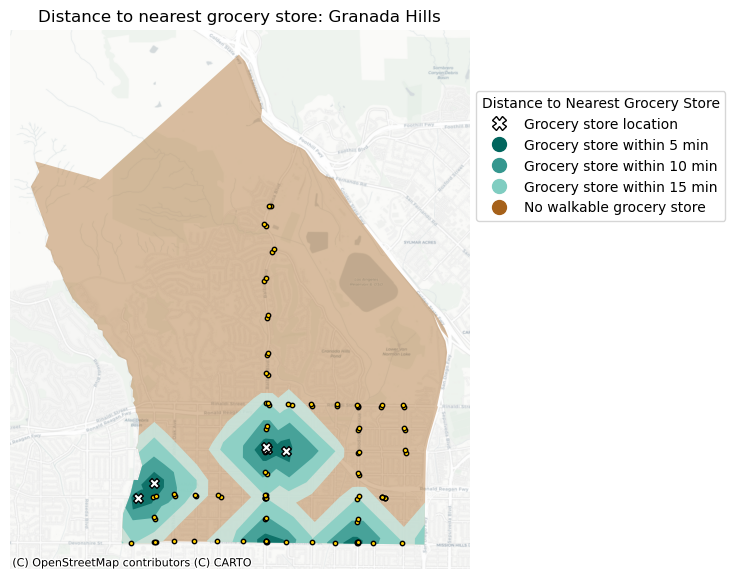

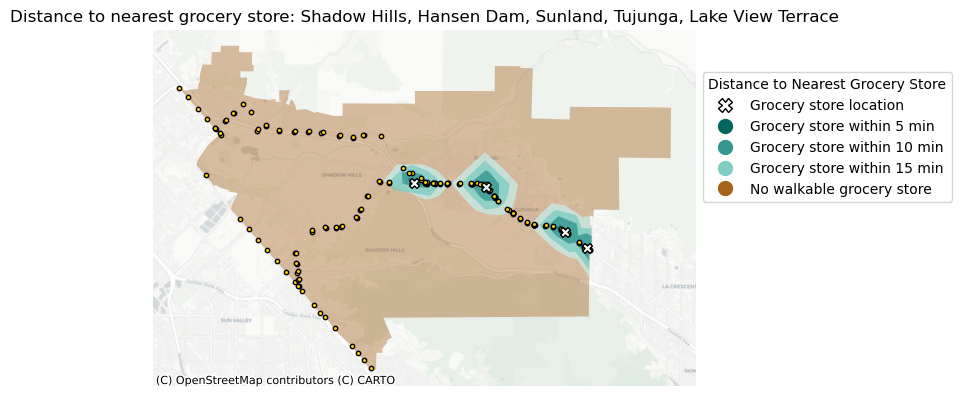

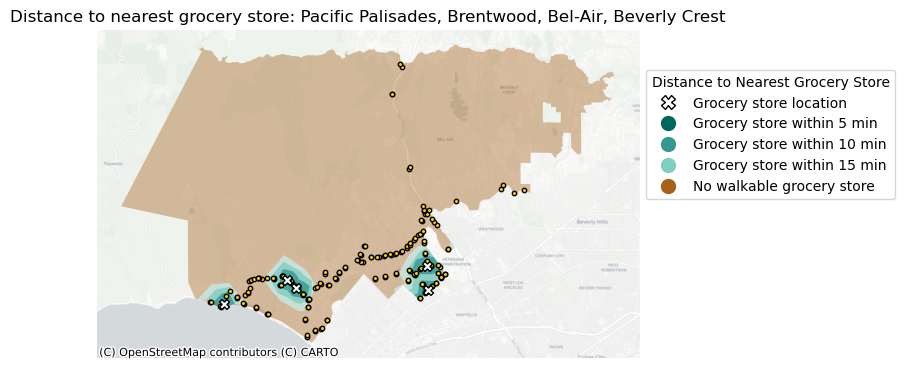

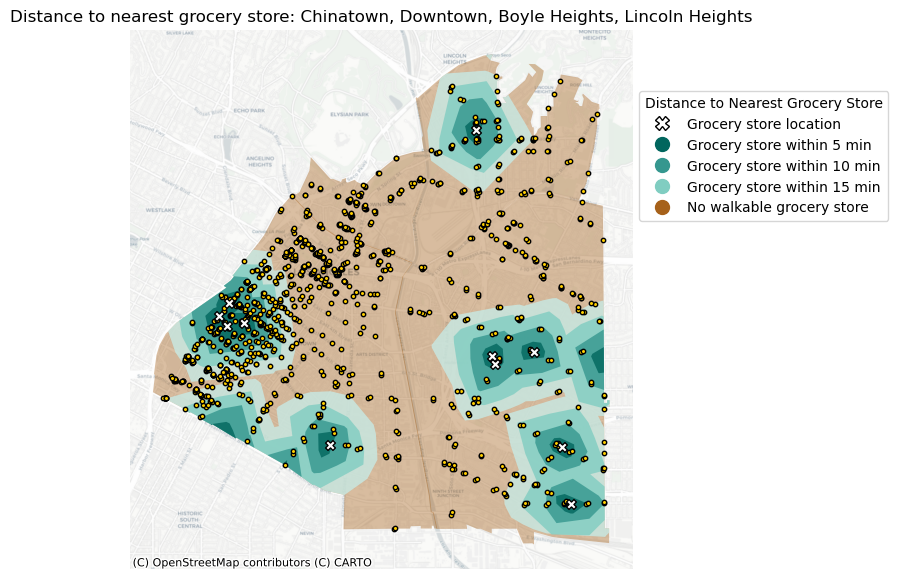

In [69]:
neighborhood_map(['Granada Hills'])
neighborhood_map(['Shadow Hills', 'Hansen Dam', 'Sunland', 'Tujunga', 'Lake View Terrace'])
neighborhood_map(['Pacific Palisades', 'Brentwood','Bel-Air','Beverly Crest'])
neighborhood_map(['Chinatown', 'Downtown','Boyle Heights','Lincoln Heights'])

### Division of Labor:
<b>Carolyn:</b> Carolyn focused on analyses related to fixed route transit.<br>
<b>Lucy:</b> Lucy focused on analyses related to the senior population and Metro Micro zones.<br>
<b>Monisha:</b> Monisha focused on analyses related to household vehicle access and grocery store access.